# Введение в PyTorch

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*4br4WmxNo0jkcsY796jGDQ.jpeg" width=240>

**На этом уроке мы рассмотрим как при помощи PyTorch:**
- Работать с данными
- Создавать свои модели нейросетей (на примере полносвязных и сверточных сетей)
- Обучать созданные модели
- Сохранять и загружать обученные модели (checkpoints)
- Делать предсказания (инференс)
- Ускорить инференс при помощи компиляции моделей (PyTorch 2.0)
- Transfer Lerning из одного датасета в другой

В качестве датасетов будем использовать MNIST и CIFAR10.

**Для начала импортируем необходимые библиотеки:**

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.__version__

'2.2.0.dev20230913'

In [2]:
# Вспомогательная функция для визуализации данных:
def show(img, title=''):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
    plt.show()

## 1 Работа с данными

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

**Загрузка датасета**

In [4]:
# Скачиваем данные для обучения:
training_data = datasets.MNIST(
    root="./dataset",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Скачиваем данные для теста:
test_data = datasets.MNIST(
    root="./dataset",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:42<00:00, 235776.03it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 161853.50it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 987187.82it/s] 


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1328766.74it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [5]:
type(training_data)

torchvision.datasets.mnist.MNIST

**Визуализация данных**

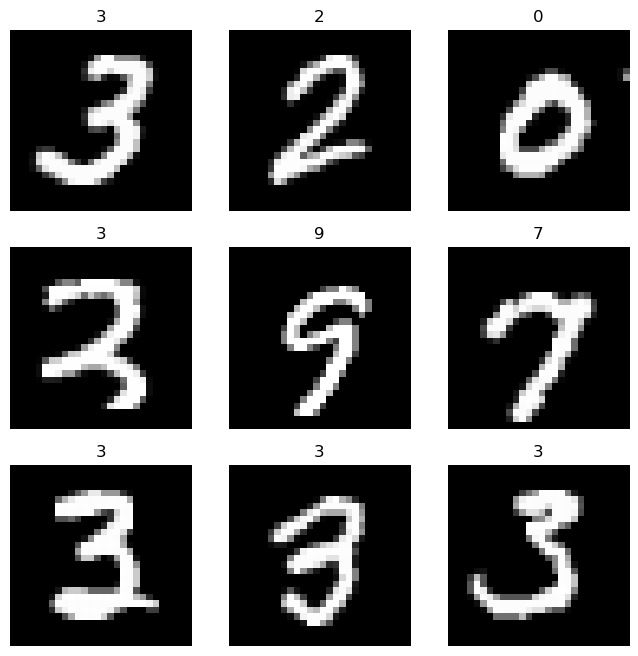

In [6]:
# Визуализируем рандомные сэмплы из MNIST:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeeze() - удаляем все измерения размером 1
plt.show();


figure: (torch.Size([1, 28, 28]), <class 'torch.Tensor'>)


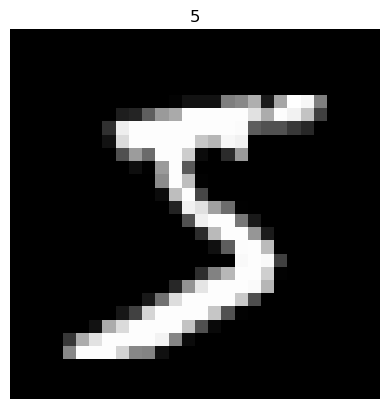

In [7]:
img, label = training_data[0]
print(f'figure: {img.shape, type(img)}')

plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray") # squeeze() - удаляем все измерения размером 1

plt.show()

**Итерирование через данные**

In [8]:
batch_size = 64

# Создаем data loaders:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape o

## 2 Создание модели
<img src="images/nn_picture.png">

#### Слои
[**Flatten**](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) -  трансформирует 2D изображение (28x28 пикселей) в вектор (784 пикселей).

[**Linear**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) -  применяет линейную трансформацию к входным данным используя веса модели и смещение (bias):
<img src="images/linear.png">

[**ReLU**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) -  функция активации, добавляет нейлинейность в модель, что позволяет модели аппроксимировать нейлинейные функции:
<img src="images/relu.png">

[**Sequential**](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) -  упорядоченный контейнер модулей нейронной сети, предназначенный для быстрого создания сетей с последовательной архитектурой. Данные будут проходить слои модели в том порядке, в котором они описаны.

[**Softmax**](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) -  это обобщение логистической функции на несколько измерений, используется для нормализации выходных данных сети (в диапазон значений [0,1], которые в сумме дают 1):
<img src="images/softmax.png">

In [9]:
# Выбираем девайс (cpu или gpu), на котором будут происходит вычисления:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Определяем кастомную модель (Sequential):
class NeuralNetworkSeq(nn.Module):
    def __init__(self, input_size=(28,28,1), output_size=10):
        super(NeuralNetworkSeq, self).__init__()
        self.flatten = nn.Flatten()
        self.output = nn.Linear(512, output_size)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size[0]*input_size[1]*input_size[2], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            self.output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_seq = NeuralNetworkSeq().to(device)
print(model_seq)

Using cpu device
NeuralNetworkSeq(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
# Определяем кастомную модель:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=(28,28,1), output_size=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size[0]*input_size[1]*input_size[2], 512)
        self.fc2 = nn.Linear(512, 512)
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        logits = self.output(x)

        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


In [11]:
# Мы можем итерироваться через параметры (веса) нашей модели:
for name, param in model.named_parameters():
    print(f"Имя: {name} | Размер: {param.size()} | Значения : {param[:2]} \n")

Имя: fc1.weight | Размер: torch.Size([512, 784]) | Значения : tensor([[ 0.0267,  0.0111,  0.0344,  ...,  0.0018, -0.0307,  0.0171],
        [ 0.0134, -0.0160,  0.0271,  ..., -0.0352,  0.0060,  0.0129]],
       grad_fn=<SliceBackward0>) 

Имя: fc1.bias | Размер: torch.Size([512]) | Значения : tensor([ 0.0302, -0.0353], grad_fn=<SliceBackward0>) 

Имя: fc2.weight | Размер: torch.Size([512, 512]) | Значения : tensor([[-0.0429,  0.0309, -0.0167,  ...,  0.0414, -0.0038,  0.0336],
        [-0.0189, -0.0371, -0.0099,  ..., -0.0202,  0.0379, -0.0304]],
       grad_fn=<SliceBackward0>) 

Имя: fc2.bias | Размер: torch.Size([512]) | Значения : tensor([ 0.0098, -0.0035], grad_fn=<SliceBackward0>) 

Имя: output.weight | Размер: torch.Size([10, 512]) | Значения : tensor([[ 0.0391, -0.0076,  0.0252,  ..., -0.0331, -0.0041, -0.0368],
        [ 0.0161, -0.0402, -0.0173,  ...,  0.0356, -0.0420,  0.0004]],
       grad_fn=<SliceBackward0>) 

Имя: output.bias | Размер: torch.Size([10]) | Значения : tensor(

Ненормализованные вероятности:
 tensor([[-0.0073,  0.0372,  0.0372,  0.0219, -0.0325,  0.0949,  0.0534,  0.0002,
         -0.0705,  0.0465]])
Нормализованные вероятности:
 tensor([[0.0974, 0.1018, 0.1018, 0.1003, 0.0950, 0.1079, 0.1035, 0.0981, 0.0914,
         0.1028]])


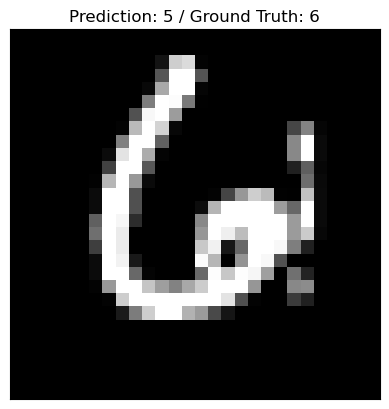

In [12]:
# Пропустим рандомное изображение из MNIST через нашу еще необученную модель:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
X, Y = training_data[sample_idx]
X = X.to(device)

# Forward pass:
logits = model(X)
pred_prob = nn.Softmax(dim=1)(logits)
Y_pred = pred_prob.argmax(1)

print('Ненормализованные вероятности:\n', logits.cpu().detach())
print('Нормализованные вероятности:\n', pred_prob.cpu().detach())
text = f"Prediction: {Y_pred.item()} / Ground Truth: {Y}"
show(X.cpu().squeeze(), title=text)

## 3 Обучение (оптимизация параметров модели)

In [13]:
# Функция для обучения модели:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Делаем предсказания:
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Функция для тестирования обученной модели:
def test(dataloader, model, loss_fn, verbose=True, iterations=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if iterations is not None and i >= iterations:
                break

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Функции потерь / Loss Functions

[**MSELoss**](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) -  Mean Square Error / Squared L2 (среднеквадратичная ошибка / квадратичная L2 норма:
<img src="images/mse.png">

[**CrossEntropyLoss**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) -  Перекрестная энтропия, комбинирует Softmax и Negative Log Likelihood:
<img src="images/crossentropy.png">

### Оптимайзеры / Optimizers
[**SGD**](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=sgd#torch.optim.SGD) -  Стохастический градиентный спуск, принимает аргументы:
- параметры модели,
- learning rate (скорость обучения),
- momentum (импульс),
- weight_decay (распад весов, помогает регуляризировать модель, тем самым предотвращая переобучения).

[**Adam**](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam) -  Оптимизационный алгоритм Адама:
- параметры модели,
- learning rate (скорость обучения),
- betas,
- weight_decay.

In [14]:
# Инициализируем модель и data loaders:
model = NeuralNetwork().to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 5
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.314137  [    0/60000]
loss: 0.285540  [ 6400/60000]
loss: 0.201380  [12800/60000]
loss: 0.270838  [19200/60000]
loss: 0.153154  [25600/60000]
loss: 0.330610  [32000/60000]
loss: 0.135243  [38400/60000]
loss: 0.230702  [44800/60000]
loss: 0.297435  [51200/60000]
loss: 0.184547  [57600/60000]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.139320 

Epoch 2
-------------------------------
loss: 0.070362  [    0/60000]
loss: 0.084236  [ 6400/60000]
loss: 0.114440  [12800/60000]
loss: 0.106387  [19200/60000]
loss: 0.035627  [25600/60000]
loss: 0.093691  [32000/60000]
loss: 0.066900  [38400/60000]
loss: 0.117005  [44800/60000]
loss: 0.090579  [51200/60000]
loss: 0.131664  [57600/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.093786 

Epoch 3
-------------------------------
loss: 0.052846  [    0/60000]
loss: 0.056772  [ 6400/60000]
loss: 0.056578  [12800/60000]
loss: 0.099457  [19200/60000]
loss: 0.034931  [25600/60000]
loss: 0.063557  [32000/600

## 4 Сохранение и загрузка обученной модели

In [15]:
!mkdir checkpoints

# Сохраняем checkpoint:
checkpoint_path = './checkpoints/mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)
print("Saved PyTorch Model State to {}".format(checkpoint_path))

Saved PyTorch Model State to ./checkpoints/mnist_checkpoint.pth


In [16]:
# Создаем модель (объект класса NeuralNetwork) и загружаем параметры из checkpoint:
model = NeuralNetwork()
model.load_state_dict(torch.load(checkpoint_path))
# print (model.state_dict())

<All keys matched successfully>

In [17]:
# Протестируем загруженную модель (чтобы убедиться что все правильно загрузилось):
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.133034 



## 5 Делаем предсказания (inference)

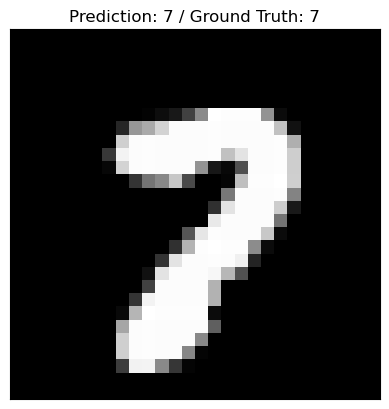

In [18]:
# Опишем название классов:
classes = ['0','1','2','3','4','5','6','7','8','9']

sample_idx = torch.randint(len(test_data), size=(1,)).item()
x, y = test_data[sample_idx][0], test_data[sample_idx][1]
x = x.to(device)

model.eval()
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    text = f"Prediction: {predicted} / Ground Truth: {actual}"
    show(x.cpu().squeeze(), title=text)

## 6 Обучаем сверточную сеть
LeNet архитектура:
<img src="images/cnn.jpg">

In [19]:
import torch.nn.functional as F     # imports activation functions

class CNN(nn.Module):
    def __init__(self, out_size, use_bn=True):
        super(CNN, self).__init__()
        # Describe layers:
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     # 1: in channels, 32: out channels, 3: kernel size, 1: stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)         # 9216: in channels, 128: out channels
        self.fc2 = nn.Linear(128, out_size)
        self.use_bn = use_bn
        if use_bn:
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)

    # Forward propagation:
    def forward(self, x):
        '''
        x reprenets our input data
        '''
        # Pass data through conv's layers:
        x = self.conv1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = F.relu(x)

        # Run max pooling over x:
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)

        # Pass data through FC's layers:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

cnn_model = CNN(10).to(device)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
# Инициализируем модель и data loaders:
cnn_model = CNN(10).to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 5
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer)
    test(test_dataloader, cnn_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.368638  [    0/60000]
loss: 0.352690  [ 6400/60000]
loss: 0.285595  [12800/60000]
loss: 0.238358  [19200/60000]
loss: 0.211498  [25600/60000]
loss: 0.194376  [32000/60000]
loss: 0.163192  [38400/60000]
loss: 0.253891  [44800/60000]
loss: 0.208936  [51200/60000]
loss: 0.236021  [57600/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.059242 

Epoch 2
-------------------------------
loss: 0.029933  [    0/60000]
loss: 0.287297  [ 6400/60000]
loss: 0.105537  [12800/60000]
loss: 0.100092  [19200/60000]
loss: 0.108543  [25600/60000]
loss: 0.268039  [32000/60000]
loss: 0.098055  [38400/60000]
loss: 0.186412  [44800/60000]
loss: 0.201593  [51200/60000]
loss: 0.101832  [57600/60000]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.045785 

Epoch 3
-------------------------------
loss: 0.073531  [    0/60000]
loss: 0.163212  [ 6400/60000]
loss: 0.056093  [12800/60000]
loss: 0.146281  [19200/60000]
loss: 0.023748  [25600/60000]
loss: 0.153074  [32000/600

In [21]:
# Протестируем обученную модель:
cnn_model = cnn_model.to(device)
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, cnn_model, loss_fn)

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.044112 



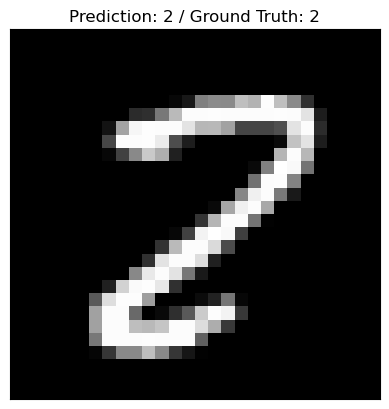

In [22]:
# Опишем название классов:
classes = ['0','1','2','3','4','5','6','7','8','9']

# Делаем предсказание:
sample_idx = 444
x, y = test_data[sample_idx][0], test_data[sample_idx][1]
x = x.to(device)

cnn_model.eval()
with torch.no_grad():
    pred = cnn_model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    text = f"Prediction: {predicted} / Ground Truth: {actual}"
    show(x.cpu().squeeze(), title=text)